# SVD/DMD analysis of a slice extracted from a 3D simulation

In [1]:
from os import makedirs
import numpy as np
import torch as pt
from scipy.signal import welch
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.animation import FuncAnimation, FFMpegWriter
from flowtorch.analysis import SVD, DMD
from utils import add_stl_patch, normalize_frequency, spatio_temporal_correlation
from flow_conditions import CHORD, A_INF, U_INF

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

data = "./output/naca0012_data/"
output = "./output/naca0012_analysis/slice/"
makedirs(output, exist_ok=True)

In [2]:
times = pt.load(f"{data}slice/times_ref1_z25.pt")
x = pt.load(f"{data}slice/x_ref1_z25.pt") / CHORD
y = pt.load(f"{data}slice/y_ref1_z25.pt") / CHORD
w = pt.load(f"{data}slice/w_ref1_z25.pt").sqrt().unsqueeze(-1)
n_points = w.shape[0]
n_times = times.shape[0]
dm = {}
## density
dm["rho"] = pt.load(f"{data}slice/dm_ref1_z25.pt")[3*n_points:4*n_points, :] * w
## velocity
dm["uxy"] = pt.load(f"{data}slice/dm_ref1_z25.pt")[:2*n_points, :] * w.repeat((2, 1))
## velocity and speed of sound
dm["uxya"] = pt.zeros((3*n_points, times.shape[0]))
dm_full = pt.load(f"{data}slice/dm_ref1_z25.pt")
dm["uxya"][:2*n_points, :] = dm_full[:2*n_points, :] * w.repeat((2, 1))
kappa = pt.tensor(1.4)
scale = pt.sqrt(2.0 / (kappa * (kappa - 1.0)))
U = (dm_full[:n_points, :]**2 + dm_full[n_points:2*n_points, :]**2 + dm_full[2*n_points:3*n_points, :]**2).sqrt()
Ma = dm_full[4*n_points:, :]
dm["uxya"][2*n_points:, :] = scale * (U / Ma) * w

## SVD analysis

### Density

In [3]:
svd = SVD(dm["rho"], rank=10000)
print(svd)

SVD of a 128523x1136 data matrix
Selected/optimal rank: 1136/469
data type: torch.float32 (4b)
truncated SVD size: 561.8811Mb


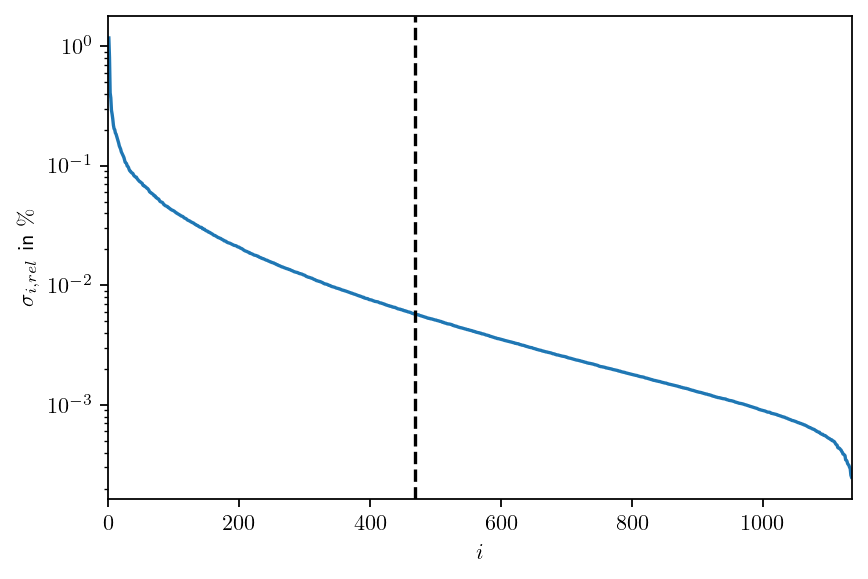

In [4]:
plt.plot(range(1, n_times), svd.s_rel[1:n_times])
plt.axvline(svd.opt_rank, ls="--", c="k")
plt.xlabel(r"$i$")
plt.ylabel(r"$\sigma_{i,rel}$ in $\%$")
plt.yscale("log")
plt.xlim(0, n_times)
plt.show()

In [5]:
dt = (times[1] - times[0]).item()

for i in range(1, 9):
    f, a = welch(svd.V[:, i].numpy(), fs=1/dt, nperseg=n_times, nfft=n_times)
    amax = np.argmax(a),
    print(f"mode {i}:", normalize_frequency(f[amax]), a[amax])
    print("-"*20)

mode 1: 0.6512806515740933 5.6849505e-05
--------------------
mode 2: 0.6512806515740933 5.2432675e-05
--------------------
mode 3: 1.3025613031481866 1.6381922e-05
--------------------
mode 4: 1.3025613031481866 2.6635524e-05
--------------------
mode 5: 2.4748664759815546 4.7180924e-06
--------------------
mode 6: 8.59690460077803 7.775159e-06
--------------------
mode 7: 2.0840980850370987 6.4650944e-06
--------------------
mode 8: 1.0420490425185494 5.6542135e-06
--------------------


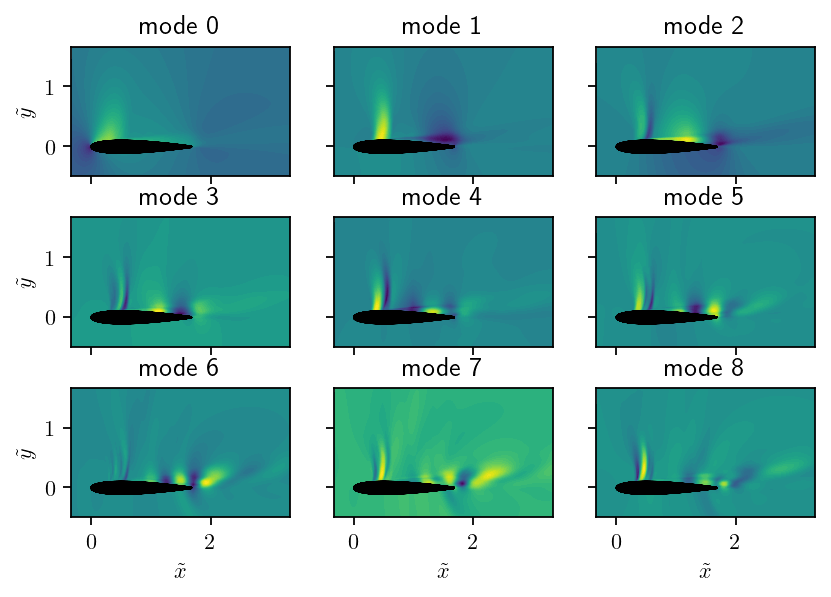

In [6]:
fig, axarr = plt.subplots(3, 3, figsize=(6, 4), sharex=True, sharey=True)

count = 0
for row in range(3):
    for col in range(3):
        axarr[row, col].tricontourf(x, y, svd.U[:, count]/w.squeeze(), levels=50, cmap="viridis")
        add_stl_patch(axarr[row, col], scale=1.0/CHORD)
        axarr[row, col].set_aspect("equal")
        axarr[row, col].set_xlim(-0.2/CHORD, 2.0/CHORD)
        axarr[row, col].set_ylim(-0.3/CHORD, 1.0/CHORD)
        axarr[row, col].set_title(f"mode {count}")
        count += 1

for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")
for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{y}$")
    
plt.savefig(f"{output}svd_modes_rho.png", bbox_inches="tight")
plt.show()

### Velocity

In [7]:
svd = SVD(dm["uxy"], rank=10000)
print(svd)

SVD of a 257046x1136 data matrix
Selected/optimal rank: 1136/464
data type: torch.float32 (4b)
truncated SVD size: 1.0926Gb


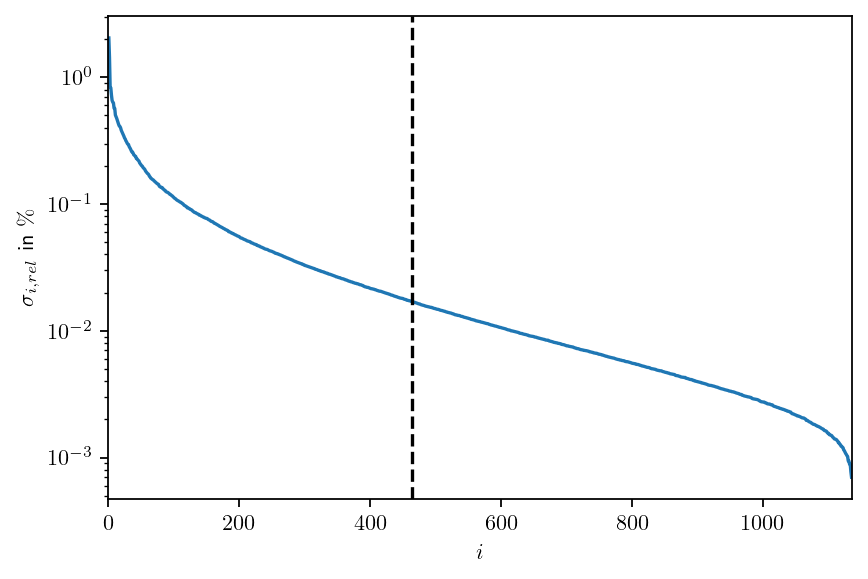

In [8]:
plt.plot(range(1, n_times), svd.s_rel[1:n_times])
plt.axvline(svd.opt_rank, ls="--", c="k")
plt.xlabel(r"$i$")
plt.ylabel(r"$\sigma_{i,rel}$ in $\%$")
plt.yscale("log")
plt.xlim(0, n_times)
plt.show()

In [9]:
for i in range(1, 9):
    f, a = welch(svd.V[:, i].numpy(), fs=1/dt, nperseg=n_times, nfft=n_times)
    amax = np.argmax(a),
    print(f"mode {i}:", normalize_frequency(f[amax]), a[amax])
    print("-"*20)

mode 1: 0.6512806515740933 5.381953e-05
--------------------
mode 2: 0.6512806515740933 5.4875993e-05
--------------------
mode 3: 12.634844640537409 1.5652051e-05
--------------------
mode 4: 12.634844640537409 1.6232683e-05
--------------------
mode 5: 1.4328174334630053 1.7523904e-05
--------------------
mode 6: 8.59690460077803 8.800125e-06
--------------------
mode 7: 8.59690460077803 8.670486e-06
--------------------
mode 8: 1.3025613031481866 2.448622e-05
--------------------


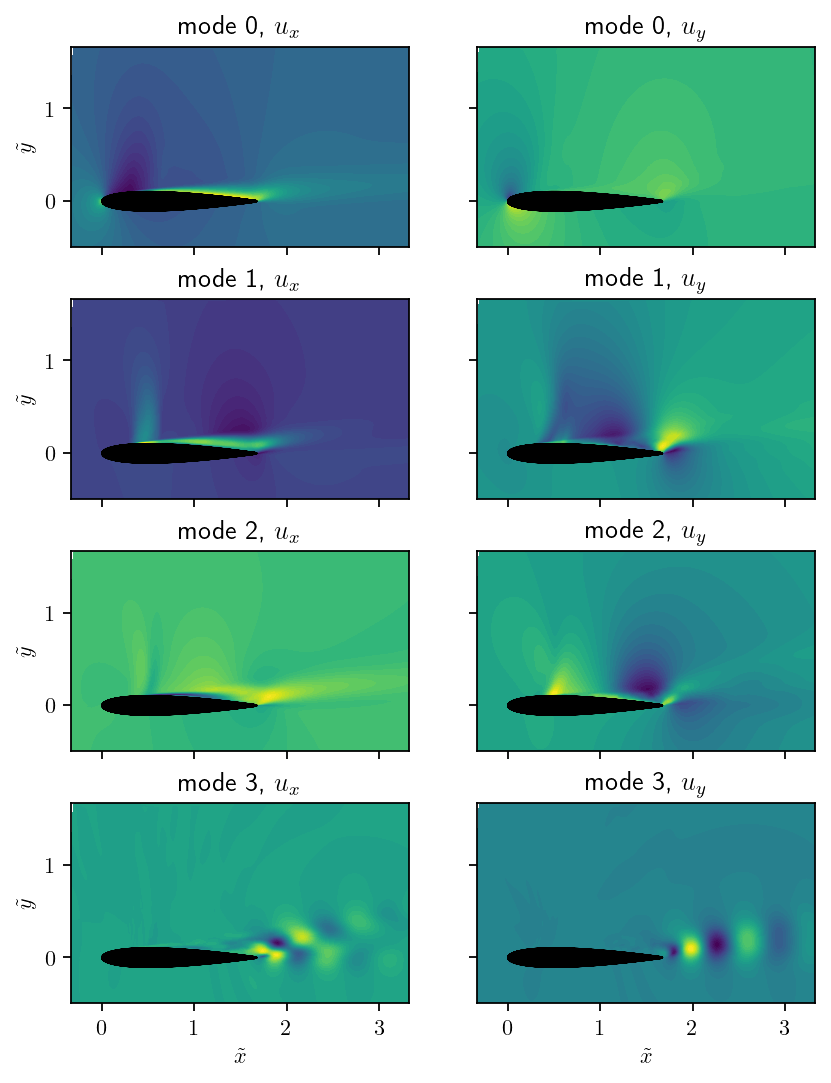

In [10]:
fig, axarr = plt.subplots(4, 2, figsize=(6, 8), sharex=True, sharey=True)

for row in range(4):
    axarr[row, 0].tricontourf(x, y, svd.U[:n_points, row]/w.squeeze(), levels=50, cmap="viridis")
    axarr[row, 1].tricontourf(x, y, svd.U[n_points:, row]/w.squeeze(), levels=50, cmap="viridis")
    axarr[row, 0].set_title(f"mode {row}, " + r"$u_x$")
    axarr[row, 1].set_title(f"mode {row}, " + r"$u_y$")
    for ax in axarr[row, :]:
        add_stl_patch(ax, scale=1.0/CHORD)
        ax.set_aspect("equal")
        ax.set_xlim(-0.2/CHORD, 2.0/CHORD)
        ax.set_ylim(-0.3/CHORD, 1.0/CHORD)
        
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")
for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{y}$")
    
plt.savefig(f"{output}svd_modes_uxy.png", bbox_inches="tight")
plt.show()

### Velocity and speed of sound

In [11]:
svd = SVD(dm["uxya"], rank=10000)
print(svd)

SVD of a 385569x1136 data matrix
Selected/optimal rank: 1136/461
data type: torch.float32 (4b)
truncated SVD size: 1.6365Gb


In [12]:
for i in range(1, 9):
    f, a = welch(svd.V[:, i].numpy(), fs=1/dt, nperseg=n_times, nfft=n_times)
    amax = np.argmax(a),
    print(f"mode {i}:", normalize_frequency(f[amax]), a[amax])
    print("-"*20)

mode 1: 0.6512806515740933 5.3969827e-05
--------------------
mode 2: 0.6512806515740933 5.4865202e-05
--------------------
mode 3: 12.634844640537409 1.5595127e-05
--------------------
mode 4: 12.634844640537409 1.6200853e-05
--------------------
mode 5: 1.4328174334630053 1.7705976e-05
--------------------
mode 6: 8.59690460077803 8.0157615e-06
--------------------
mode 7: 1.3025613031481866 2.1606511e-05
--------------------
mode 8: 8.59690460077803 8.956329e-06
--------------------


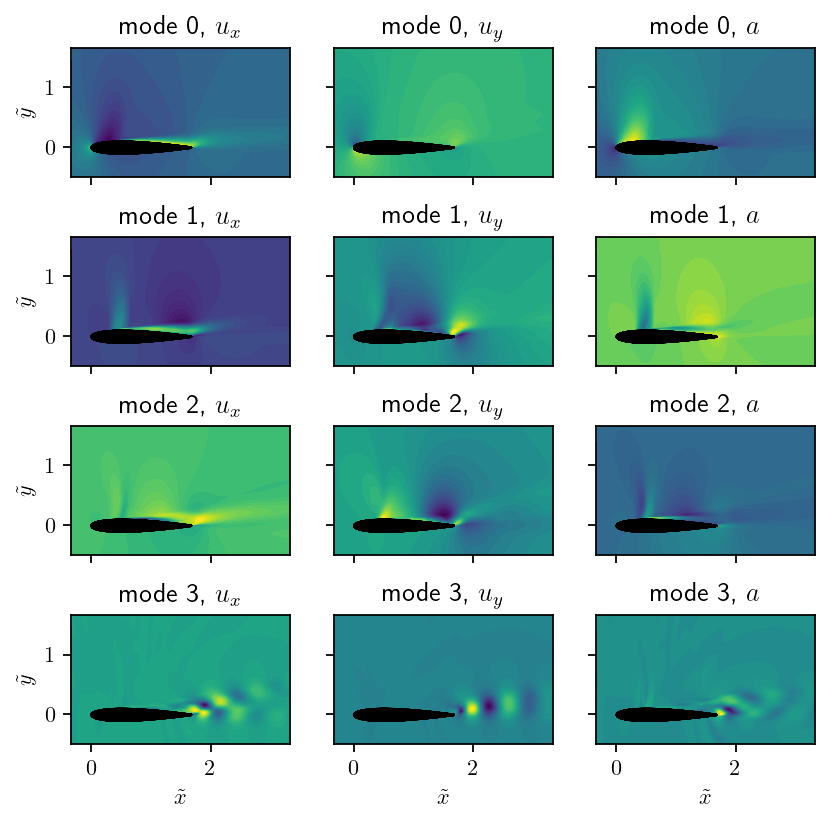

In [13]:
fig, axarr = plt.subplots(4, 3, figsize=(6, 6), sharex=True, sharey=True)

for row in range(4):
    axarr[row, 0].tricontourf(x, y, svd.U[:n_points, row]/w.squeeze(), levels=50, cmap="viridis")
    axarr[row, 1].tricontourf(x, y, svd.U[n_points:2*n_points, row]/w.squeeze(), levels=50, cmap="viridis")
    axarr[row, 2].tricontourf(x, y, svd.U[2*n_points:, row]/w.squeeze(), levels=50, cmap="viridis")
    axarr[row, 0].set_title(f"mode {row}, " + r"$u_x$")
    axarr[row, 1].set_title(f"mode {row}, " + r"$u_y$")
    axarr[row, 2].set_title(f"mode {row}, " + r"$a$")
    for ax in axarr[row, :]:
        add_stl_patch(ax, scale=1.0/CHORD)
        ax.set_aspect("equal")
        ax.set_xlim(-0.2/CHORD, 2.0/CHORD)
        ax.set_ylim(-0.3/CHORD, 1.0/CHORD)
        
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")
for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{y}$")
    
plt.savefig(f"{output}svd_modes_uxya.png", bbox_inches="tight")
plt.show()

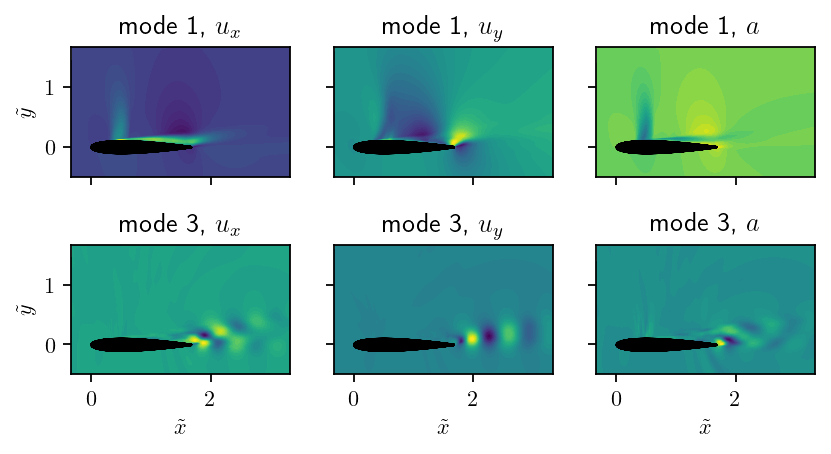

In [14]:
fig, axarr = plt.subplots(2, 3, figsize=(6, 3), sharex=True, sharey=True)

for row, mi in enumerate((1, 3)):
    axarr[row, 0].tricontourf(x, y, svd.U[:n_points, mi]/w.squeeze(), levels=50, cmap="viridis")
    axarr[row, 1].tricontourf(x, y, svd.U[n_points:2*n_points, mi]/w.squeeze(), levels=50, cmap="viridis")
    axarr[row, 2].tricontourf(x, y, svd.U[2*n_points:, mi]/w.squeeze(), levels=50, cmap="viridis")
    axarr[row, 0].set_title(f"mode {mi}, " + r"$u_x$")
    axarr[row, 1].set_title(f"mode {mi}, " + r"$u_y$")
    axarr[row, 2].set_title(f"mode {mi}, " + r"$a$")
    for ax in axarr[row, :]:
        add_stl_patch(ax, scale=1.0/CHORD)
        ax.set_aspect("equal")
        ax.set_xlim(-0.2/CHORD, 2.0/CHORD)
        ax.set_ylim(-0.3/CHORD, 1.0/CHORD)
        
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")
for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{y}$")
    
plt.savefig(f"{output}svd_modes_uxya_article.png", bbox_inches="tight")
plt.show()

In [8]:
del svd

## DMD analysis
### Density

In [9]:
dmd = DMD(dm["rho"], dt, optimal=True)
# udmd = DMD(dm["rho"], dt, optimal=True, unitary=True, tlsq=False)
print(dmd)

SVD:
SVD of a 128523x1135 data matrix
Selected/optimal rank: 469/469
data type: torch.float32 (4b)
truncated SVD size: 231.9720Mb
LSQ:
Overall DMD size: 693.5330Mb


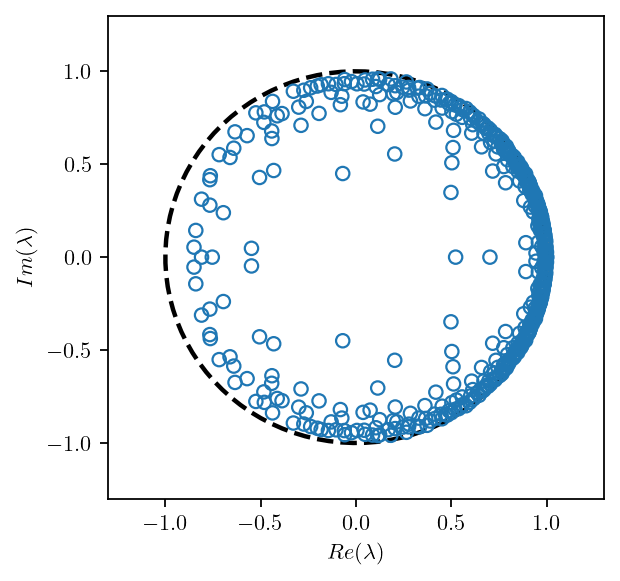

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
t = pt.linspace(0, 2 * np.pi, 100)
ax.plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
ax.scatter(dmd.eigvals.real, dmd.eigvals.imag, facecolors='none', edgecolors="C0", zorder=6)
# ax.scatter(udmd.eigvals.real, udmd.eigvals.imag, marker="+", color="C2", lw=1, zorder=6)
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_xlabel(r"$Re(\lambda)$")
ax.set_ylabel(r"$Im(\lambda)$")
plt.show()

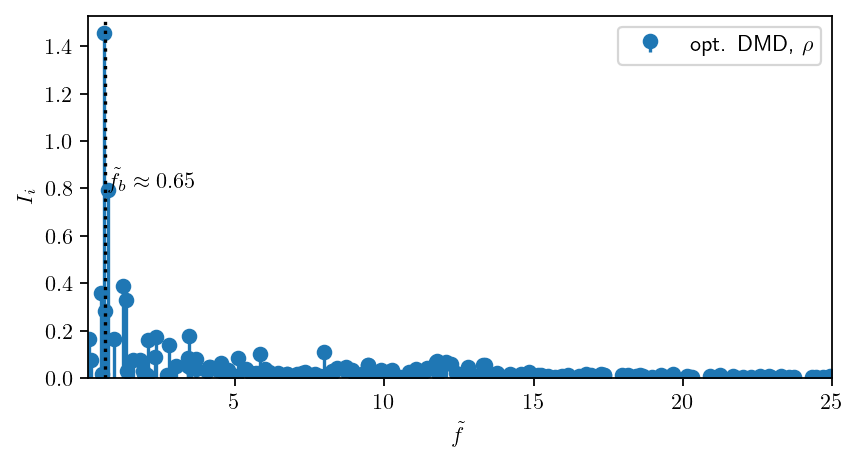

In [11]:
fb = 0.65173183

pos = dmd.frequency > 1
# upos = udmd.frequency > 1
imp = dmd.integral_contribution
# uimp = udmd.integral_contribution

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.stem(normalize_frequency(dmd.frequency[pos].numpy()), imp[pos].numpy(), basefmt="none", linefmt="C0-", markerfmt="C0o", label=r"opt. DMD, $\rho$")
# ax.stem(normalize_frequency(udmd.frequency[upos].numpy()), uimp[upos].numpy(), basefmt="none", linefmt="C2--", markerfmt="C2+", label=r"UDMD, $\rho$")
ax.set_xlabel(r"$\tilde{f}$")
ax.set_ylabel(r"$I_i$")
ax.legend()
ax.set_xlim(0.1, 25)
ax.set_ylim(0)
ax.axvline(fb, ls=":", c="k")
ax.text(0.76, 0.8, r"$\tilde{{f}}_{b}\approx 0.65$")

plt.savefig(f"{output}dmd_freq_rho.svg", bbox_inches="tight")
plt.savefig(f"{output}dmd_freq_rho.pdf", bbox_inches="tight")

plt.show()

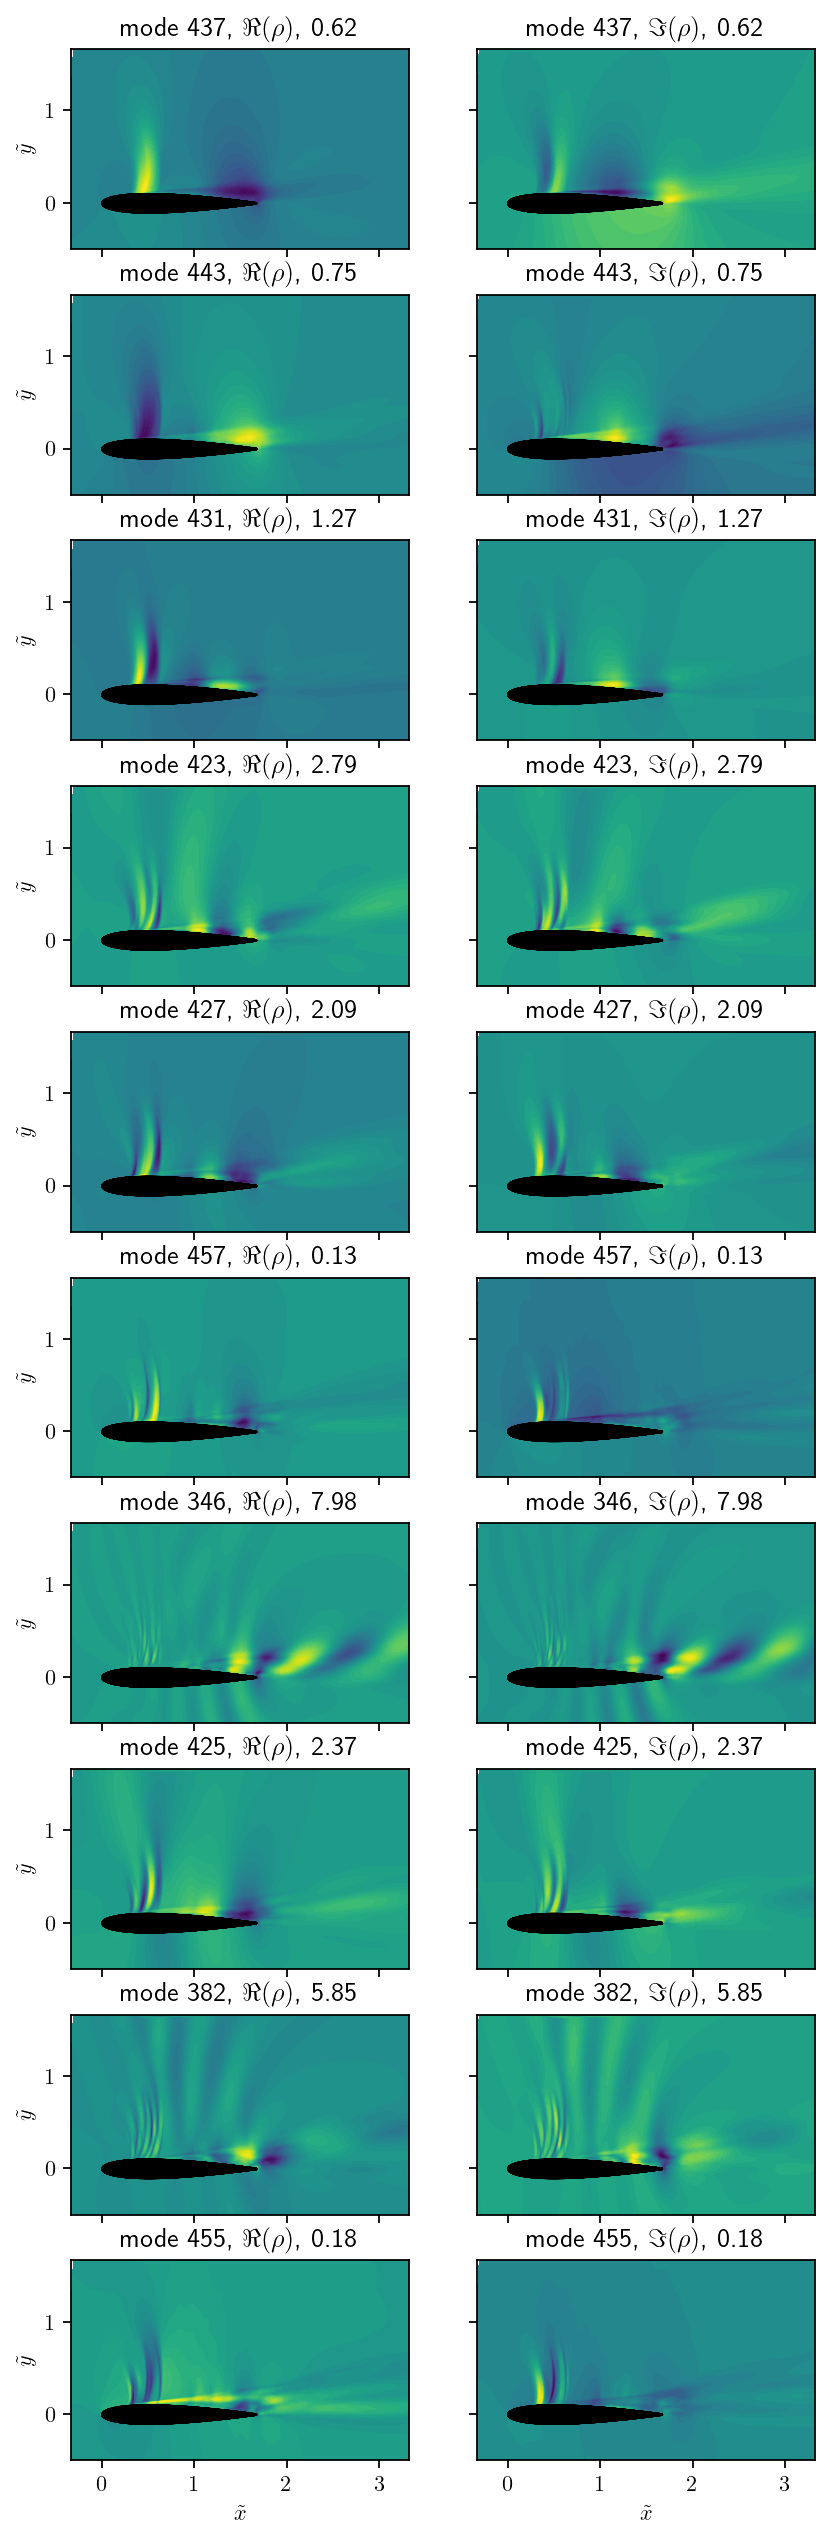

In [19]:
n_modes = 40
top = dmd.top_modes(n_modes, integral=True)
top = [mi for mi in top if dmd.frequency[mi] > 1]

n_plot = 10
fig, axarr = plt.subplots(n_plot, 2, figsize=(6, 2*n_plot), sharex=True, sharey=True)

for i, mi in enumerate(top[:n_plot]):
    axarr[i, 0].tricontourf(x, y, dmd.modes[:, mi].real/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 1].tricontourf(x, y, dmd.modes[:, mi].imag/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 0].set_title(f"mode {mi}" + r", $\Re (\rho)$" + f", {normalize_frequency(dmd.frequency[mi]):2.2f}")
    axarr[i, 1].set_title(f"mode {mi}" + r", $\Im (\rho)$" + f", {normalize_frequency(dmd.frequency[mi]):2.2f}")
    for ax in axarr[i, :]:
        add_stl_patch(ax, scale=1.0/CHORD)
        ax.set_aspect("equal")
        ax.set_xlim(-0.2/CHORD, 2.0/CHORD)
        ax.set_ylim(-0.3/CHORD, 1.0/CHORD)

for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{y}$")
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")

plt.show()

In [23]:
#n_modes = 40
#top = udmd.top_modes(n_modes, integral=True)
#top = [mi for mi in top if udmd.frequency[mi] > 1]

#n_plot = 10
#fig, axarr = plt.subplots(n_plot, 2, figsize=(6, 2*n_plot), sharex=True, sharey=True)

#for i, mi in enumerate(top[:n_plot]):
#    axarr[i, 0].tricontourf(x, y, udmd.modes[:, mi].real/w.squeeze(), levels=50, cmap="viridis")
#    axarr[i, 1].tricontourf(x, y, udmd.modes[:, mi].imag/w.squeeze(), levels=50, cmap="viridis")
#    axarr[i, 0].set_title(f"mode {mi}" + r", $\Re (\rho)$" + f", {normalize_frequency(udmd.frequency[mi]):2.2f}")
#    axarr[i, 1].set_title(f"mode {mi}" + r", $\Im (\rho)$" + f", {normalize_frequency(udmd.frequency[mi]):2.2f}")
#    for ax in axarr[i, :]:
#        add_stl_patch(ax, scale=1.0/CHORD)
#        ax.set_aspect("equal")
#        ax.set_xlim(-0.2/CHORD, 2.0/CHORD)
#        ax.set_ylim(-0.3/CHORD, 1.0/CHORD)

#for ax in axarr[:, 0]:
#    ax.set_ylabel(r"$y/c$")
#for ax in axarr[-1, :]:
#    ax.set_xlabel(r"$x/c$")

#plt.show()

### Velocity

In [12]:
dmd = DMD(dm["uxy"], dt, optimal=True)
#udmd = DMD(dm["uxy"], dt, optimal=True, unitary=True)
print(dmd)

SVD:
SVD of a 257046x1135 data matrix
Selected/optimal rank: 464/464
data type: torch.float32 (4b)
truncated SVD size: 456.9872Mb
LSQ:
Overall DMD size: 1.3365Gb


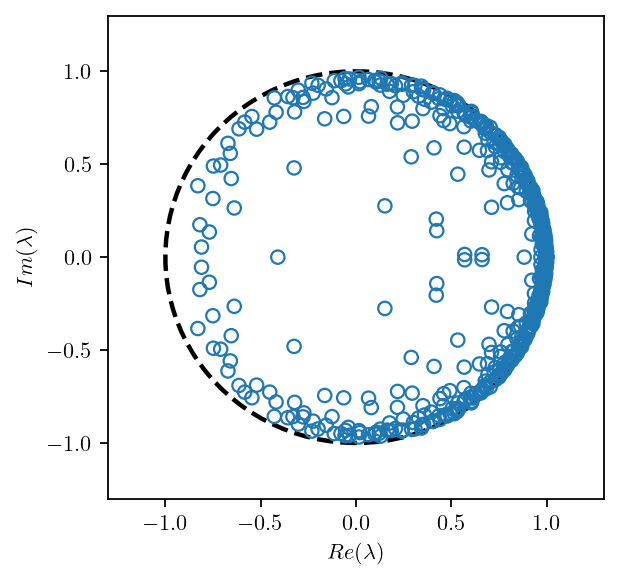

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
t = pt.linspace(0, 2 * np.pi, 100)
ax.plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
ax.scatter(dmd.eigvals.real, dmd.eigvals.imag, facecolors='none', edgecolors="C0", zorder=6)
#ax.scatter(udmd.eigvals.real, udmd.eigvals.imag, marker="+", color="C2", lw=1, zorder=6)
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_xlabel(r"$Re(\lambda)$")
ax.set_ylabel(r"$Im(\lambda)$")
plt.show()

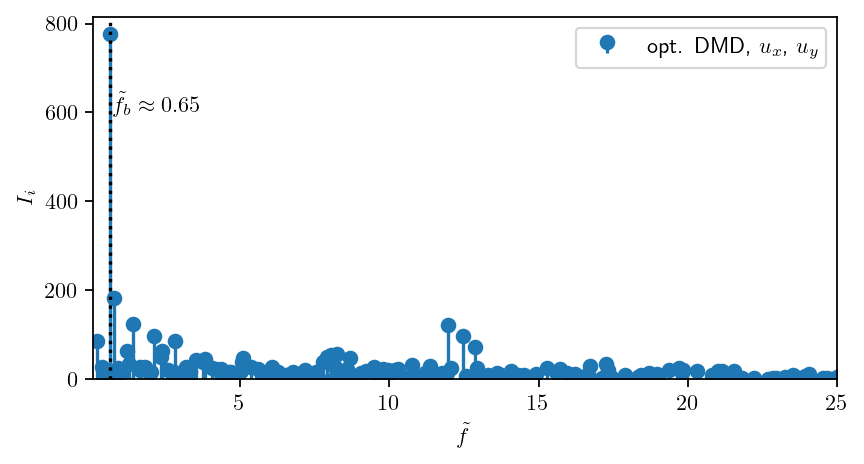

In [14]:
fb = 0.65173183

pos = dmd.frequency > 1
#upos = udmd.frequency > 1
imp = dmd.integral_contribution
#uimp = udmd.integral_contribution

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.stem(normalize_frequency(dmd.frequency[pos].numpy()), imp[pos].numpy(), basefmt="none", linefmt="C0-", markerfmt="C0o", label=r"opt. DMD, $u_x$, $u_y$")
#ax.stem(normalize_frequency(udmd.frequency[upos].numpy()), uimp[upos].numpy(), basefmt="none", linefmt="C2--", markerfmt="C2+", label=r"UDMD, $u_x$, $u_y$")
ax.set_xlabel(r"$\tilde{f}$")
ax.set_ylabel(r"$I_i$")
ax.legend()
ax.set_xlim(0.1, 25)
ax.set_ylim(0)
ax.axvline(fb, ls=":", c="k")
ax.text(0.75, 600, r"$\tilde{{f}}_{b}\approx 0.65$")

plt.savefig(f"{output}dmd_freq_uxy.svg", bbox_inches="tight")
plt.savefig(f"{output}dmd_freq_uxy.pdf", bbox_inches="tight")

plt.show()

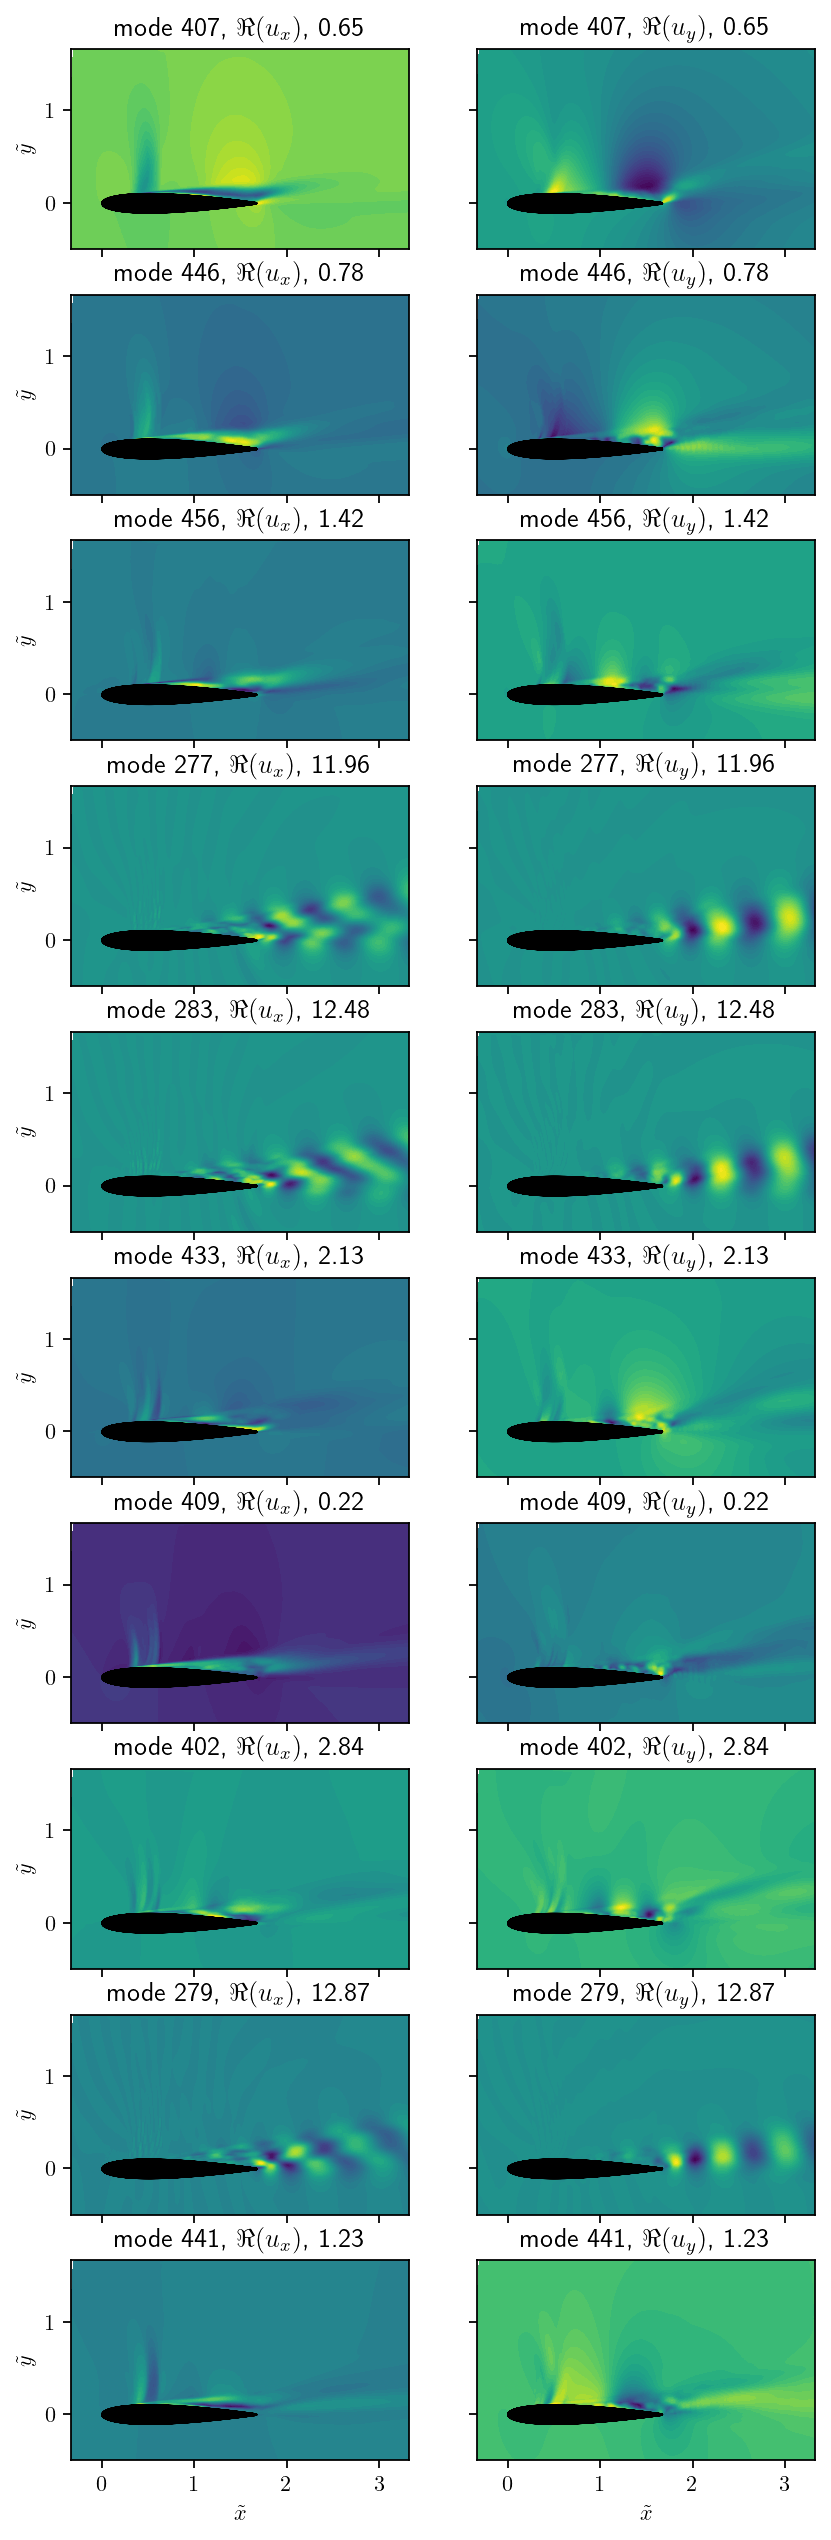

In [23]:
n_modes = 40
top = dmd.top_modes(n_modes, integral=True)
top = [mi for mi in top if dmd.frequency[mi] > 1]

n_plot = 10
fig, axarr = plt.subplots(n_plot, 2, figsize=(6, 2*n_plot), sharex=True, sharey=True)

for i, mi in enumerate(top[:n_plot]):
    axarr[i, 0].tricontourf(x, y, dmd.modes[:n_points, mi].real/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 1].tricontourf(x, y, dmd.modes[n_points:, mi].imag/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 0].set_title(f"mode {mi}" + r", $\Re (u_x)$" + f", {normalize_frequency(dmd.frequency[mi]):2.2f}")
    axarr[i, 1].set_title(f"mode {mi}" + r", $\Re (u_y)$" + f", {normalize_frequency(dmd.frequency[mi]):2.2f}")
    for ax in axarr[i, :]:
        add_stl_patch(ax, scale=1.0/CHORD)
        ax.set_aspect("equal")
        ax.set_xlim(-0.2/CHORD, 2.0/CHORD)
        ax.set_ylim(-0.3/CHORD, 1.0/CHORD)

for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{y}$")
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")

plt.show()

In [28]:
#n_modes = 40
#top = udmd.top_modes(n_modes, integral=True)
#top = [mi for mi in top if udmd.frequency[mi] > 1]

#n_plot = 10
#fig, axarr = plt.subplots(n_plot, 2, figsize=(6, 2*n_plot), sharex=True, sharey=True)

#for i, mi in enumerate(top[:n_plot]):
#    axarr[i, 0].tricontourf(x, y, udmd.modes[:n_points, mi].real/w.squeeze(), levels=50, cmap="viridis")
#    axarr[i, 1].tricontourf(x, y, udmd.modes[n_points:, mi].imag/w.squeeze(), levels=50, cmap="viridis")
#    axarr[i, 0].set_title(f"mode {mi}" + r", $\Re (u_x)$" + f", {normalize_frequency(udmd.frequency[mi]):2.2f}")
#    axarr[i, 1].set_title(f"mode {mi}" + r", $\Re (u_y)$" + f", {normalize_frequency(udmd.frequency[mi]):2.2f}")
#    for ax in axarr[i, :]:
#        add_stl_patch(ax, scale=1.0/CHORD)
#        ax.set_aspect("equal")
#        ax.set_xlim(-0.2/CHORD, 2.0/CHORD)
#        ax.set_ylim(-0.3/CHORD, 1.0/CHORD)

#for ax in axarr[:, 0]:
#    ax.set_ylabel(r"$y/c$")
#for ax in axarr[-1, :]:
#    ax.set_xlabel(r"$x/c$")

#plt.show()

### Velocity and speed of sound

In [6]:
dmd = DMD(dm["uxya"], dt, optimal=True)
#udmd = DMD(dm["uxya"], dt, rank=50, optimal=True, unitary=True)
print(dmd)

SVD:
SVD of a 385569x1135 data matrix
Selected/optimal rank: 460/460
data type: torch.float32 (4b)
truncated SVD size: 678.5748Mb
LSQ:
Overall DMD size: 1.9857Gb


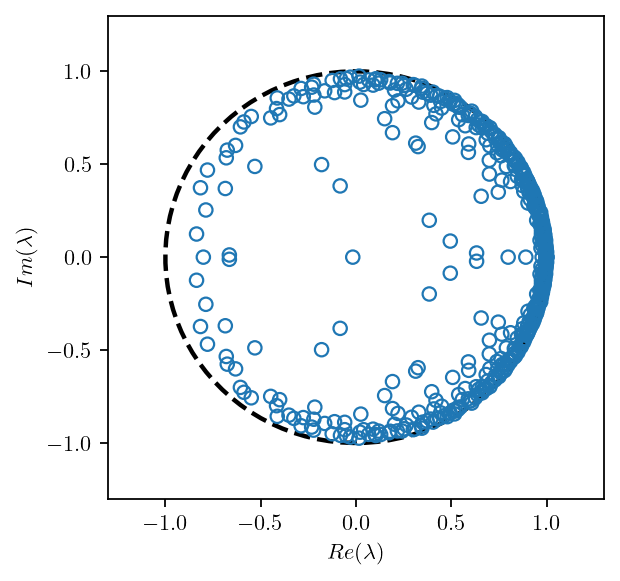

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
t = pt.linspace(0, 2 * np.pi, 100)
ax.plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
ax.scatter(dmd.eigvals.real, dmd.eigvals.imag, facecolors='none', edgecolors="C0", zorder=6)
#ax.scatter(udmd.eigvals.real, udmd.eigvals.imag, marker="+", color="C2", lw=1, zorder=6)
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_xlabel(r"$Re(\lambda)$")
ax.set_ylabel(r"$Im(\lambda)$")
plt.show()

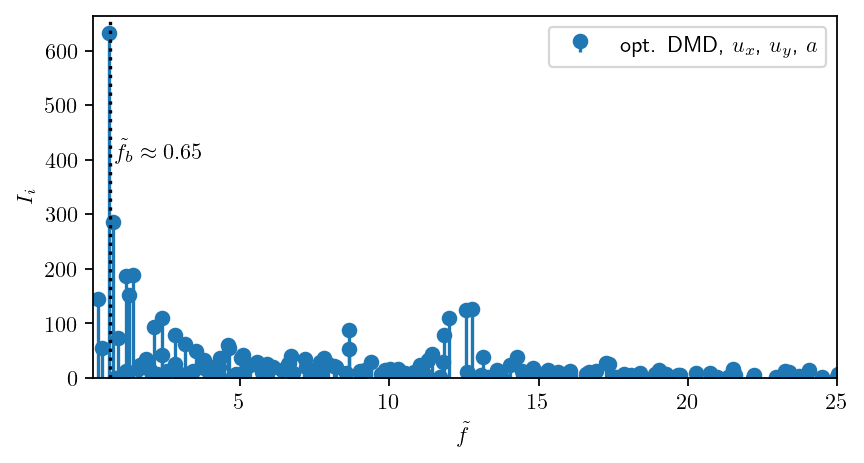

In [8]:
fb = 0.65173183

pos = dmd.frequency > 1
#upos = udmd.frequency > 1
imp = dmd.integral_contribution
#uimp = udmd.integral_contribution

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.stem(normalize_frequency(dmd.frequency[pos].numpy()), imp[pos].numpy(), basefmt="none", linefmt="C0-", markerfmt="C0o", label=r"opt. DMD, $u_x$, $u_y$, $a$")
#ax.stem(normalize_frequency(udmd.frequency[upos].numpy()), uimp[upos].numpy(), basefmt="none", linefmt="C2--", markerfmt="C2+", label=r"UDMD, $u_x$, $u_y$, $a$")
ax.set_xlabel(r"$\tilde{f}$")
ax.set_ylabel(r"$I_i$")
ax.legend()
ax.set_xlim(0.1, 25)
ax.set_ylim(0)
ax.axvline(fb, ls=":", c="k")
ax.text(0.84, 400, r"$\tilde{{f}}_{b}\approx 0.65$")

plt.savefig(f"{output}dmd_freq_uxya.svg", bbox_inches="tight")
plt.savefig(f"{output}dmd_freq_uxya.pdf", bbox_inches="tight")

plt.show()

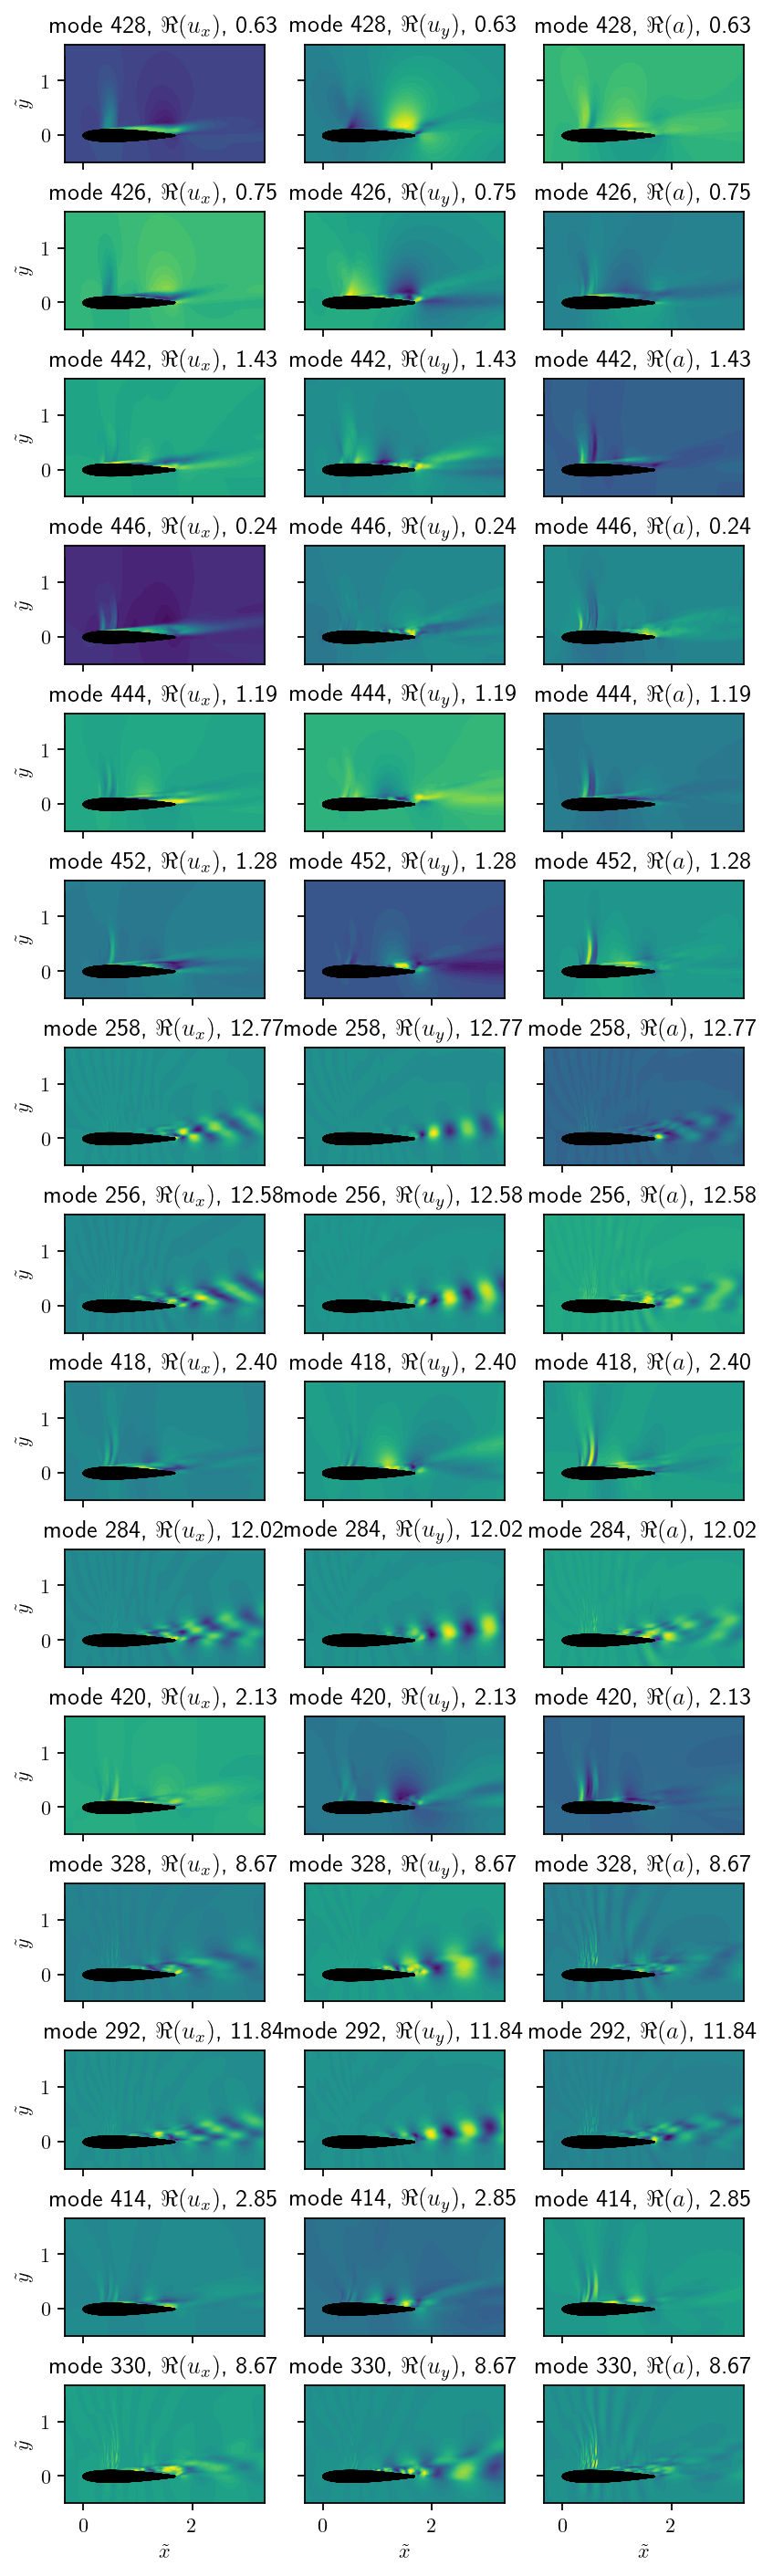

In [10]:
n_modes = 60
top = dmd.top_modes(n_modes, integral=True)
top = [mi for mi in top if dmd.frequency[mi] > 1]

n_plot = 15
fig, axarr = plt.subplots(n_plot, 3, figsize=(6, 1.5*n_plot), sharex=True, sharey=True)

for i, mi in enumerate(top[:n_plot]):
    axarr[i, 0].tricontourf(x, y, dmd.modes[:n_points, mi].real/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 1].tricontourf(x, y, dmd.modes[n_points:2*n_points, mi].imag/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 2].tricontourf(x, y, dmd.modes[2*n_points:, mi].imag/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 0].set_title(f"mode {mi}" + r", $\Re (u_x)$" + f", {normalize_frequency(dmd.frequency[mi]):2.2f}")
    axarr[i, 1].set_title(f"mode {mi}" + r", $\Re (u_y)$" + f", {normalize_frequency(dmd.frequency[mi]):2.2f}")
    axarr[i, 2].set_title(f"mode {mi}" + r", $\Re (a)$" + f", {normalize_frequency(dmd.frequency[mi]):2.2f}")
    for ax in axarr[i, :]:
        add_stl_patch(ax, scale=1.0/CHORD)
        ax.set_aspect("equal")
        ax.set_xlim(-0.2/CHORD, 2.0/CHORD)
        ax.set_ylim(-0.3/CHORD, 1.0/CHORD)

for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{y}$")
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")

plt.show()

In [69]:
#n_modes = 40
#top = udmd.top_modes(n_modes, integral=True)
#top = [mi for mi in top if udmd.frequency[mi] > 1]

#n_plot = 10
#fig, axarr = plt.subplots(n_plot, 3, figsize=(6, 1.5*n_plot), sharex=True, sharey=True)

#for i, mi in enumerate(top[:n_plot]):
#    axarr[i, 0].tricontourf(x, y, udmd.modes[:n_points, mi].real/w.squeeze(), levels=50, cmap="viridis")
#    axarr[i, 1].tricontourf(x, y, udmd.modes[n_points:2*n_points, mi].imag/w.squeeze(), levels=50, cmap="viridis")
#    axarr[i, 2].tricontourf(x, y, udmd.modes[2*n_points:, mi].imag/w.squeeze(), levels=50, cmap="viridis")
#    axarr[i, 0].set_title(f"mode {mi}" + r", $\Re (u_x)$" + f", {normalize_frequency(udmd.frequency[mi]):2.2f}")
#    axarr[i, 1].set_title(f"mode {mi}" + r", $\Re (u_y)$" + f", {normalize_frequency(udmd.frequency[mi]):2.2f}")
#    axarr[i, 2].set_title(f"mode {mi}" + r", $\Re (a)$" + f", {normalize_frequency(udmd.frequency[mi]):2.2f}")
#    for ax in axarr[i, :]:
#        add_stl_patch(ax, scale=1.0/CHORD)
#        ax.set_aspect("equal")
#        ax.set_xlim(-0.2/CHORD, 2.0/CHORD)
#        ax.set_ylim(-0.3/CHORD, 1.0/CHORD)

#for ax in axarr[:, 0]:
#    ax.set_ylabel(r"$y/c$")
#for ax in axarr[-1, :]:
#    ax.set_xlabel(r"$x/c$")

#plt.show()

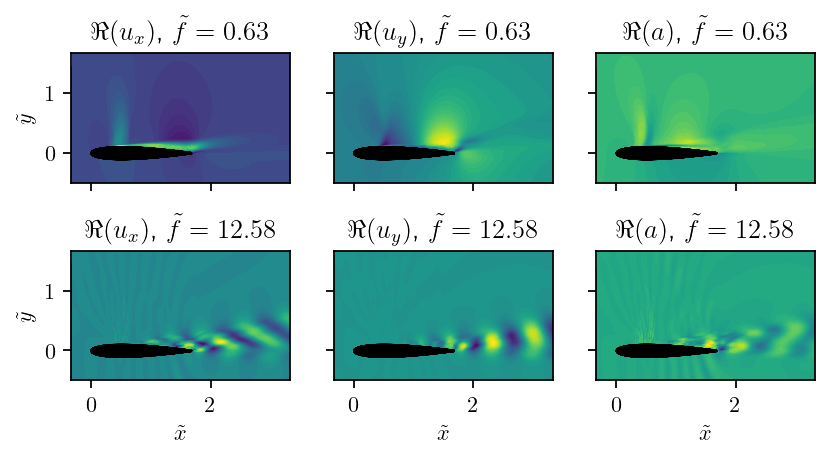

In [11]:
fig, axarr = plt.subplots(2, 3, figsize=(6, 3), sharex=True, sharey=True)

for i, mi in enumerate((428, 256)):
    axarr[i, 0].tricontourf(x, y, dmd.modes[:n_points, mi].real/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 1].tricontourf(x, y, dmd.modes[n_points:2*n_points, mi].imag/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 2].tricontourf(x, y, dmd.modes[2*n_points:, mi].imag/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 0].set_title(r"$\Re (u_x)$, $\tilde{{f}}={:2.2f}$".format(normalize_frequency(dmd.frequency[mi])))
    axarr[i, 1].set_title(r"$\Re (u_y)$, $\tilde{{f}}={:2.2f}$".format(normalize_frequency(dmd.frequency[mi])))
    axarr[i, 2].set_title(r"$\Re (a)$, $\tilde{{f}}={:2.2f}$".format(normalize_frequency(dmd.frequency[mi])))
    for ax in axarr[i, :]:
        add_stl_patch(ax, scale=1.0/CHORD)
        ax.set_aspect("equal")
        ax.set_xlim(-0.2/CHORD, 2.0/CHORD)
        ax.set_ylim(-0.3/CHORD, 1.0/CHORD)

for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{y}$")
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")

plt.savefig(f"{output}dmd_modes_uxya_article.png", bbox_inches="tight")
plt.show()

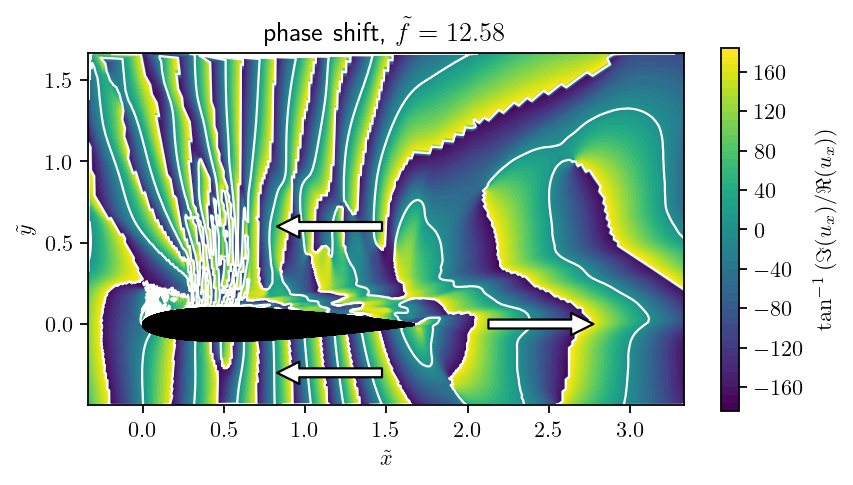

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

mi = 256
phase_ux = pt.atan2(dmd.modes[:n_points, mi].imag, dmd.modes[:n_points, mi].real)
#phase_ux = pt.atan(dmd.modes[:n_points, mi].imag/dmd.modes[:n_points, mi].real)
tri_ux = ax.tricontourf(x, y, phase_ux*180/np.pi, levels=50, cmap="viridis", vmin=-180, vmax=180)
ax.tricontour(x, y, phase_ux*180/np.pi, levels=[0], colors="w", linewidths=1, zorder=1)
bar = plt.colorbar(tri_ux, ax=ax, label=r"$\mathrm{tan}^{-1}\left(\Im (u_x) / \Re (u_x)\right)$")
add_stl_patch(ax, scale=1.0/CHORD)
ax.add_patch(
    FancyArrowPatch((1.5, 0.6), (0.8, 0.6), mutation_scale=20, fc="w")
)
ax.add_patch(
    FancyArrowPatch((1.5, -0.3), (0.8, -0.3), mutation_scale=20, fc="w")
)
ax.add_patch(
    FancyArrowPatch((2.1, 0.0), (2.8, 0.0), mutation_scale=20, fc="w")
)
ax.set_aspect("equal")
ax.set_xlim(-0.2/CHORD, 2.0/CHORD)
ax.set_ylim(-0.3/CHORD, 1.0/CHORD)
ax.set_xlabel(r"$\tilde{x}$")
ax.set_ylabel(r"$\tilde{y}$")
ax.set_title(r"phase shift, $\tilde{{f}}={:2.2f}$".format(normalize_frequency(dmd.frequency[mi])))

plt.savefig(f"{output}dmd_buffet_mode_uxya_phase.png", bbox_inches="tight")
plt.show()

In [8]:
np_line = 11
line = pt.stack((
    pt.linspace(0.7, 0.8, np_line),
    pt.linspace(0.5, 0.5, np_line),
)).T

In [9]:
mode_256 = dmd.partial_reconstruction({256})[2*n_points:, :]
mode_328 = dmd.partial_reconstruction({328})[2*n_points:, :]

In [10]:
Ul_256 = []
Ul_328 = []
for pi in range(line.shape[0]):
    closest = (pt.stack((x, y), dim=1) - line[pi]).norm(dim=1).argmin()
    Ul_256.append(mode_256[closest])
    Ul_328.append(mode_328[closest])
Ul_256 = pt.stack(Ul_256, dim=1).T
Ul_328 = pt.stack(Ul_328, dim=1).T
Ul_256 -= Ul_256.mean(dim=1).unsqueeze(-1)
Ul_328 -= Ul_328.mean(dim=1).unsqueeze(-1)

In [11]:
n_tau = 50
tau = pt.arange(-n_tau*dt, (n_tau+0.1)*dt, dt) * U_INF / CHORD
dd, tt = pt.meshgrid(line[:, 0], tau)

In [12]:
R_256 = spatio_temporal_correlation(Ul_256, n_tau)
R_328 = spatio_temporal_correlation(Ul_328, n_tau)

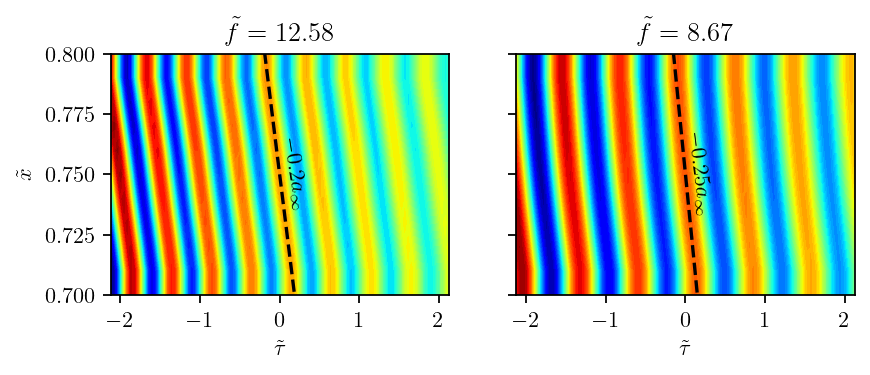

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2), sharex=True, sharey=True)
ax1.contourf(tt, dd, R_256, levels=50, cmap="jet")
ax2.contourf(tt, dd, R_328, levels=50, cmap="jet")
for ax in (ax1, ax2): 
    ax.set_ylim(line[0, 0], line[-1, 0])
    ax.set_xlabel(r"$\tilde{\tau}$")
    
slope = -A_INF*0.20/U_INF
ax1.plot(tau, tau*slope+0.75, ls="--", c="k")
ax1.text(0.0, 0.75, r"$-0.2a_\infty$", rotation=-81, va="center")
slope = -A_INF*0.25/U_INF
ax2.plot(tau, tau*slope+0.75, ls="--", c="k")
ax2.text(0.0, 0.75, r"$-0.25a_\infty$", rotation=-83, va="center")
    
ax1.set_ylabel(r"$\tilde{x}$")
ax1.set_title(r"$\tilde{{f}} = {:2.2f}$".format(normalize_frequency(dmd.frequency[256])))
ax2.set_title(r"$\tilde{{f}} = {:2.2f}$".format(normalize_frequency(dmd.frequency[328])))
plt.savefig(f"{output}dmd_mode_line_correlation.png", bbox_inches="tight")
plt.show()

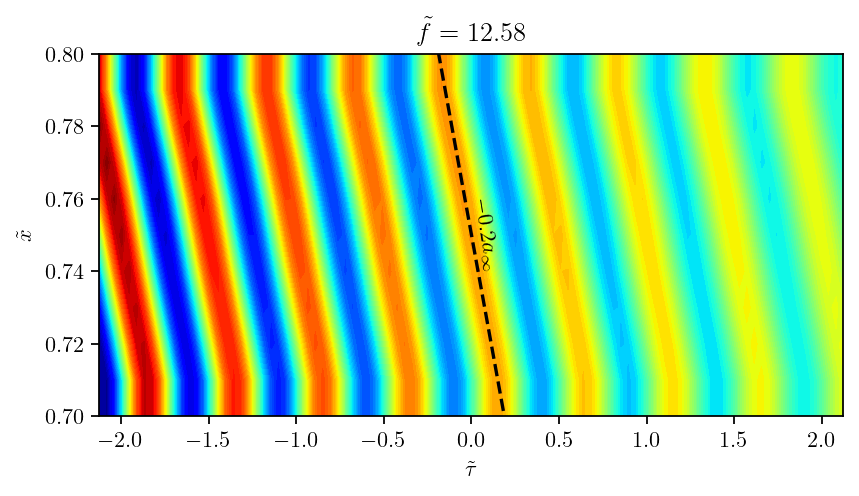

In [19]:
# reduced plot for article
fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True, sharey=True)
ax.contourf(tt, dd, R_256, levels=50, cmap="jet")
ax.set_ylim(line[0, 0], line[-1, 0])
ax.set_xlabel(r"$\tilde{\tau}$")
    
slope = -A_INF*0.2/U_INF
ax.plot(tau, tau*slope+0.75, ls="--", c="k")
ax.text(0.0, 0.75, r"$-0.2a_\infty$", rotation=-81, va="center")

ax.set_ylabel(r"$\tilde{x}$")
ax.set_title(r"$\tilde{{f}} = {:2.2f}$".format(normalize_frequency(dmd.frequency[256])))
plt.savefig(f"{output}dmd_mode_line_correlation_mode_256.png", bbox_inches="tight")
plt.show()

In [77]:
del mode_256, mode_328

## Rank influence on UDMD modes

In [7]:
test_ranks = (25, 50, 100, 200, 400)
buffet_modes, buffet_freq = {}, {}
def_buffet_modes, def_buffet_freq = {}, {}

for r in test_ranks:
    dmd = DMD(dm["uxy"], dt, rank=r, optimal=True, unitary=True)
    top = dmd.top_modes(10, integral=True)
    top = [mi for mi in top if dmd.frequency[mi] > 1]
    buffet_modes[r] = dmd.modes[:, top[0]].clone()
    buffet_freq[r] = normalize_frequency(dmd.frequency[top[0]].item())
    dmd = DMD(dm["uxy"], dt, rank=r, optimal=True, unitary=False)
    top = dmd.top_modes(10, integral=True)
    top = [mi for mi in top if dmd.frequency[mi] > 1]
    def_buffet_modes[r] = dmd.modes[:, top[0]].clone()
    def_buffet_freq[r] = normalize_frequency(dmd.frequency[top[0]].item())

In [8]:
buffet_freq, def_buffet_freq

({25: 0.6244189204082767,
  50: 0.676667352862561,
  100: 0.6266211182019648,
  200: 0.6300904235999155,
  400: 0.5997925080068257},
 {25: 0.6594862701167526,
  50: 0.6701261243516741,
  100: 0.6602164036191199,
  200: 0.6648258123399012,
  400: 0.656833291793501})

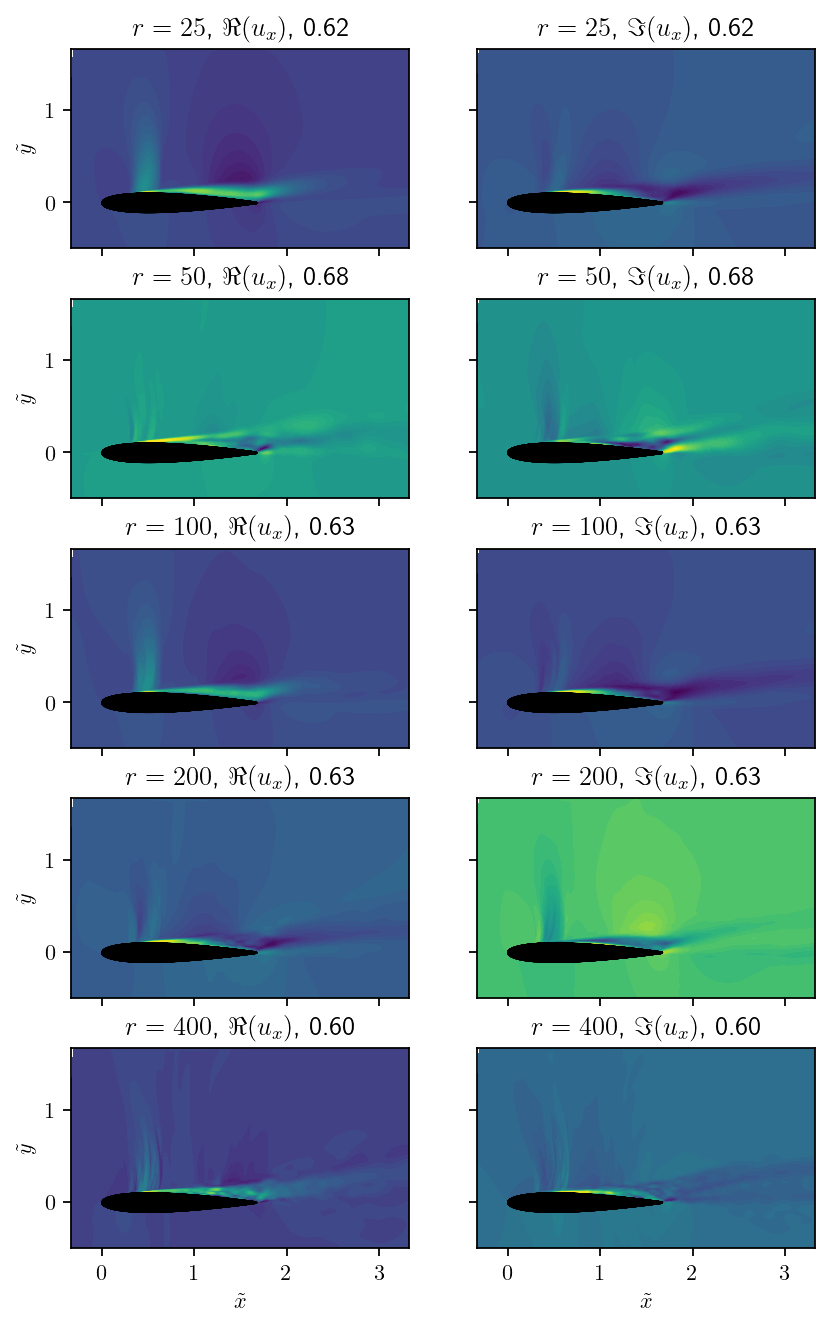

In [9]:
fig, axarr = plt.subplots(len(test_ranks), 2, figsize=(6, 2*len(test_ranks)), sharex=True, sharey=True)

for i, r in enumerate(test_ranks):
    axarr[i, 0].tricontourf(x, y, buffet_modes[r][:n_points].real/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 1].tricontourf(x, y, buffet_modes[r][:n_points].imag/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 0].set_title(f"$r={r}$" + r", $\Re (u_x)$" + f", {buffet_freq[r]:2.2f}")
    axarr[i, 1].set_title(f"$r={r}$" + r", $\Im (u_x)$" + f", {buffet_freq[r]:2.2f}")
    for ax in axarr[i, :]:
        add_stl_patch(ax, scale=1.0/CHORD)
        ax.set_aspect("equal")
        ax.set_xlim(-0.2/CHORD, 2.0/CHORD)
        ax.set_ylim(-0.3/CHORD, 1.0/CHORD)

for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{y}$")
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")

plt.show()

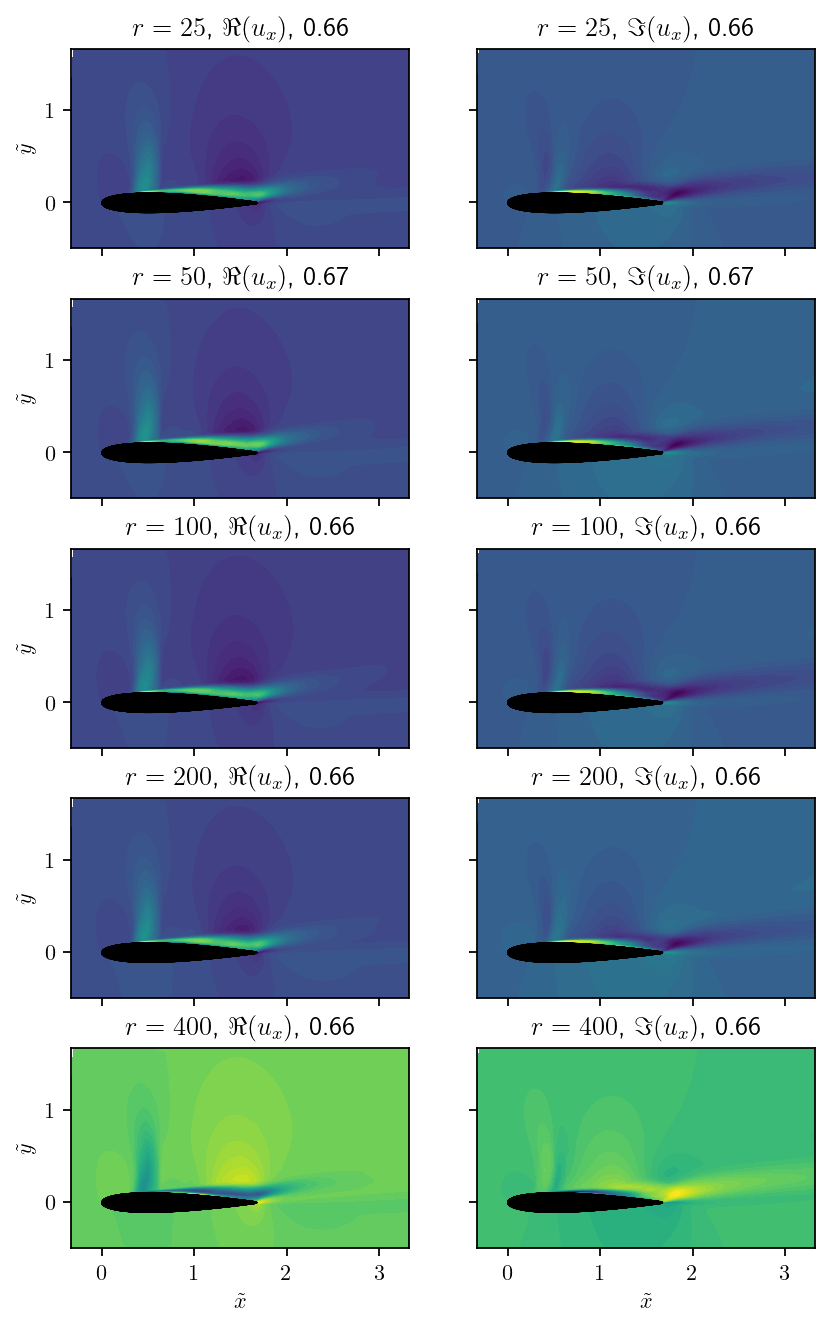

In [10]:
fig, axarr = plt.subplots(len(test_ranks), 2, figsize=(6, 2*len(test_ranks)), sharex=True, sharey=True)

for i, r in enumerate(test_ranks):
    axarr[i, 0].tricontourf(x, y, def_buffet_modes[r][:n_points].real/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 1].tricontourf(x, y, def_buffet_modes[r][:n_points].imag/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 0].set_title(f"$r={r}$" + r", $\Re (u_x)$" + f", {def_buffet_freq[r]:2.2f}")
    axarr[i, 1].set_title(f"$r={r}$" + r", $\Im (u_x)$" + f", {def_buffet_freq[r]:2.2f}")
    for ax in axarr[i, :]:
        add_stl_patch(ax, scale=1.0/CHORD)
        ax.set_aspect("equal")
        ax.set_xlim(-0.2/CHORD, 2.0/CHORD)
        ax.set_ylim(-0.3/CHORD, 1.0/CHORD)

for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{y}$")
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")

plt.show()

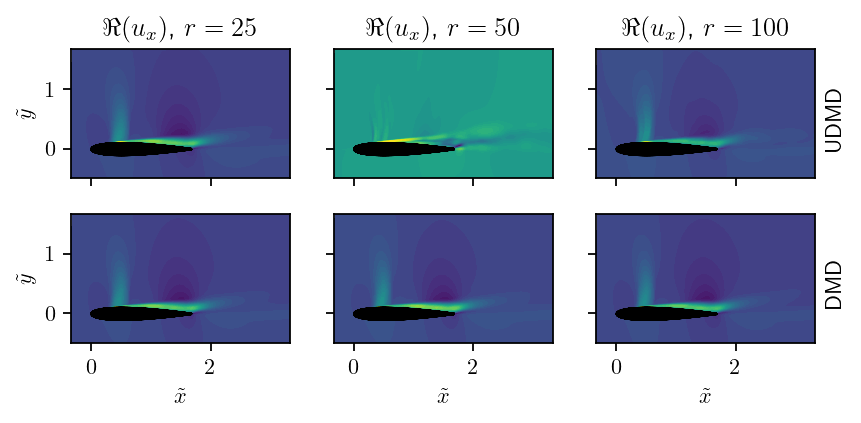

In [19]:
fig, axarr = plt.subplots(2, 3, figsize=(6, 2.5), sharex=True, sharey=True)

for i, r in enumerate((25, 50, 100)):
    axarr[0, i].tricontourf(x, y, buffet_modes[r][:n_points].real/w.squeeze(), levels=50, cmap="viridis")
    axarr[0, i].set_title(r"$\Re (u_x)$, $r={:d}$".format(r))
    add_stl_patch(axarr[0, i], scale=1.0/CHORD)
    axarr[0, i].set_aspect("equal")
    axarr[1, i].tricontourf(x, y, def_buffet_modes[r][:n_points].real/w.squeeze(), levels=50, cmap="viridis")
    add_stl_patch(axarr[1, i], scale=1.0/CHORD)
    axarr[1, i].set_aspect("equal")
    axarr[0, i].set_xlim(-0.2/CHORD, 2.0/CHORD)
    axarr[0, i].set_ylim(-0.3/CHORD, 1.0/CHORD)
    axarr[1, i].set_xlabel(r"$\tilde{x}$")
axarr[0, 0].set_ylabel(r"$\tilde{y}$")
axarr[1, 0].set_ylabel(r"$\tilde{y}$")
axarr[0, 2].text(3.5, 0.5, "UDMD", rotation=90, va="center")
axarr[1, 2].text(3.5, 0.5, "DMD", rotation=90, va="center")
plt.savefig(f"{output}udmd_modes_rank_article.png", bbox_inches="tight")
plt.show()